# Obtaining plausible simulation parameters

This notebook inspects a single cell type from 10x PBMC data and outputs the parameters of the Gaussian that summarizes the genes' parameters.

In [1]:
dataset_meta = ['pbmc_10k_v3']

cluster_names = ['Tcells']
dataset_names = [x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [x for x in dataset_meta for y in cluster_names]
# transcriptome_filepath = '../polyA_ref/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in raw_data_locations] 
# n_datasets = len(loom_filepaths)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import loompy as lp
cluster_annotations = []
for k in range(len(dataset_meta)):
    cluster_assignments = pd.read_csv(f'/home/ggorin/count_data/10x_metadata/{dataset_meta[k]}_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
#     print(cluster_assignments['Barcode'].str[-1:].unique())
    cluster_assignments['Barcode'] = cluster_assignments['Barcode'].str[:-2]
    cluster_annotations.append(cluster_assignments)


In [3]:
cf = []
thr_lb = [3e3]

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k ]
    dataset_name = raw_data_locations[len(cluster_names)*k ]
    
    clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(clusters)
        annot_bcs_in_loom = clusters['Barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = clusters['Barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        for j,cluster in enumerate(cluster_names):
            annot_bcs = clusters[clusters['Cluster']==(j+1)]['Barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')


Dataset pbmc_10k_v3. 
	11756 barcodes in loom, 11171 pass filter. 11769 in annotations; of these, 11536 in loom and 11121 in filtered loom.
	Tcells: 5376 cells in annotations. 5375 in loom. 5339 pass filter.


In [4]:
S = S[:,cf[0]]
U = U[:,cf[0]]

In [5]:
Smean = S.mean(1)
Umean = U.mean(1)

/tmp/ipykernel_3650257/1272042738.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(1/Umean,1/Smean,4,'k',alpha=0.3)


Text(0, 0.5, '$\\gamma/k$ under Poisson model')

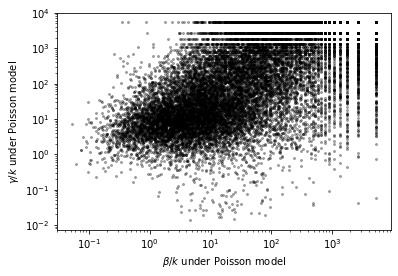

In [6]:
plt.scatter(1/Umean,1/Smean,4,'k',alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\beta/k$ under Poisson model')
plt.ylabel(r'$\gamma/k$ under Poisson model')

In [7]:
Smean.shape

(36601,)

In [13]:
S.shape

(36601, 5339)

In [12]:
gf = (Umean>0.01)&(Smean>0.01)&(S.max(1)>3)&(U.max(1)>3)

In [14]:
Smean = S[gf].mean(1)
Umean = U[gf].mean(1)

Text(0, 0.5, '$\\gamma/k$ under Poisson model')

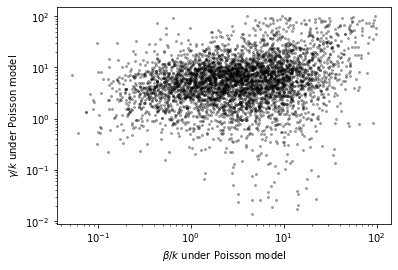

In [15]:
plt.scatter(1/Umean,1/Smean,4,'k',alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\beta/k$ under Poisson model')
plt.ylabel(r'$\gamma/k$ under Poisson model')

In [31]:
bg_vals = np.log10(np.asarray([1/Umean,1/Smean]))

In [32]:
mu = bg_vals.mean(1)

In [33]:
mu

array([0.4966826 , 0.71124953], dtype=float32)

In [34]:
cov = np.cov(bg_vals)

In [45]:
cov

array([[0.31762307, 0.06181678],
       [0.06181678, 0.23710988]])

In [41]:
from  scipy.stats import multivariate_normal
#https://gist.github.com/gwgundersen/90dfa64ca29aa8c3833dbc6b03de44be

Text(0, 0.5, '$\\log_{10} \\gamma/k$ under Poisson model')

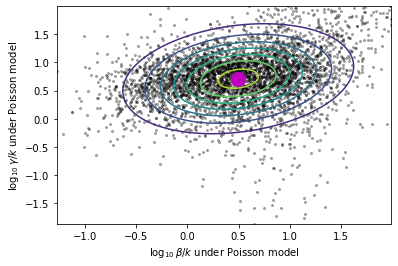

In [44]:
plt.scatter(bg_vals[0], bg_vals[1],4,'k',alpha=0.3)
plt.scatter(mu[0],mu[1],200,'m')



N    = 200
X    = np.linspace(bg_vals[0].min(), bg_vals[0].max(), N)
Y    = np.linspace(bg_vals[1].min(), bg_vals[1].max(), N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
rv   = multivariate_normal(mu,cov)
Z    = rv.pdf(pos)

plt.contour(X, Y, Z)
# plt.show()


plt.xlabel(r'$\log_{10} \beta/k$ under Poisson model')
plt.ylabel(r'$\log_{10} \gamma/k$ under Poisson model')